In [2]:
import sys
sys.path.insert(0, '../python')
sys.path.insert(0, '../')
import torch
import util
from model import handpose_model,bodypose_model
import numpy as np
import cv2
import util
import math
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
import os
import json
import torchvision
from PIL import Image
import matplotlib.cm as cm

C:\Users\garme\AppData\Local\Temp\ipykernel_32556\4067504649.py:11: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


En este script, tenemos 2 tipos conseguir las imagenes en openpose. La primera es la que más se utiliza y las más exacta, y la que he utilizado para los dos ultimos conjuntos de datos. Pero como el primero lo hice de otra forma tambien lo dejare por aqui por si ha alguien le sirve.

En el primero, primero tenemos que aplicar la demo de github de openpose, donde desde alli consiguiremos los puntos necesarios para crear openpose, y los tendremos guardados en un archivo json. En este apartado de aquí, lo que haremos es relacionar cada punto del json, para que la imagen sea representativa.

In [ ]:
# Función para dibujar los puntos y conexiones
def draw_keypoints(ax, keypoints, connections, color):
    for connection in connections:
        point1 = keypoints[connection[0]]
        point2 = keypoints[connection[1]]
        if point1[2] > 0.1 and point2[2] > 0.1:  # Draw only if confidence is high
            ax.plot([point1[0], point2[0]], [point1[1], point2[1]], color=color, lw=2)
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c=color, s=10)

# Conexiones de OpenPose para cuerpo
pose_connections = [
    (0, 1), (1, 2), (2, 3), (3, 4), (1, 5), (5, 6), (6, 7),
    (1, 8), (8, 9), (9, 10), (10, 11), (8, 12), (12, 13), (13, 14)
]

# Conexiones de OpenPose para manos
hand_connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),  # Index
    (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
    (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
    (0, 17), (17, 18), (18, 19), (19, 20)  # Pinky
]

# Función para procesar un archivo JSON y guardar la imagen resultante
def process_json_file(file_path, output_dir):
    with open(file_path) as f:
        data = json.load(f)

    keypoints = np.array(data['people'][0]['pose_keypoints_2d']).reshape(-1, 3)
    face_points = np.array(data['people'][0]['face_keypoints_2d']).reshape(-1, 3)
    left_hand_points = np.array(data['people'][0]['hand_left_keypoints_2d']).reshape(-1, 3)
    right_hand_points = np.array(data['people'][0]['hand_right_keypoints_2d']).reshape(-1, 3)

    fig, ax = plt.subplots()
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    ax.invert_yaxis()

    draw_keypoints(ax, keypoints, pose_connections, 'green')
    draw_keypoints(ax, face_points, [], 'magenta')
    draw_keypoints(ax, left_hand_points, hand_connections, 'red')
    draw_keypoints(ax, right_hand_points, hand_connections, 'blue')

    plt.axis('off')

    # Guardar la imagen
    output_file = os.path.join(output_dir, os.path.splitext(os.path.basename(file_path))[0] + '.png')
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
    plt.close()

# Función para procesar todos los archivos JSON en una carpeta
def process_all_json_files(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(input_dir, filename)
            try:
                process_json_file(file_path, output_dir)
            except:
                continue

# Ejemplo de uso
input_directory = 'openpose-1.7.0-binaries-win64-cpu-python3.7-flir-3d\openpose\JSON'
output_directory = 'Imagenes Openpose'
process_all_json_files(input_directory, output_directory)


Esto es el otro ejemplo que he utilizado para hacer el openose de las manos de conjunto de datos de KAGGLE, y para ello hemos utlizado el hand_pose_model.pth, descargado desde internet. Con este codigo, vamos encontrando los puntos claves de las manos, y como podemos ver en las primeras fotos que hace el ejemplo de uno. Luego en la ultima ejecuta de todo las fotos a la vez. 

In [2]:
model = handpose_model()

model_dict = torch.load('hand_pose_model.pth')

model.load_state_dict(util.transfer(model, model_dict))

test_image = 'CodigoAlfabeto/ALFABETO/DATA/M/DSC01254.JPG'
oriImg = cv2.imread(test_image)  


scale_search = [0.5, 1.0, 1.5, 2.0]
# scale_search = [0.5]
boxsize = 368
stride = 8
padValue = 128
thre = 0.02
multiplier = [x * boxsize / oriImg.shape[0] for x in scale_search]
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 22))
# paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, stride, padValue)
    im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5
    im = np.ascontiguousarray(im)

    data = torch.from_numpy(im).float()
    if torch.cuda.is_available():
        data = data.cuda()
    # data = data.permute([2, 0, 1]).unsqueeze(0).float()
    with torch.no_grad():
        output = model(data).numpy()

    # extract outputs, resize, and remove padding
    heatmap = np.transpose(np.squeeze(output), (1, 2, 0))  # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

    heatmap_avg += heatmap / len(multiplier)

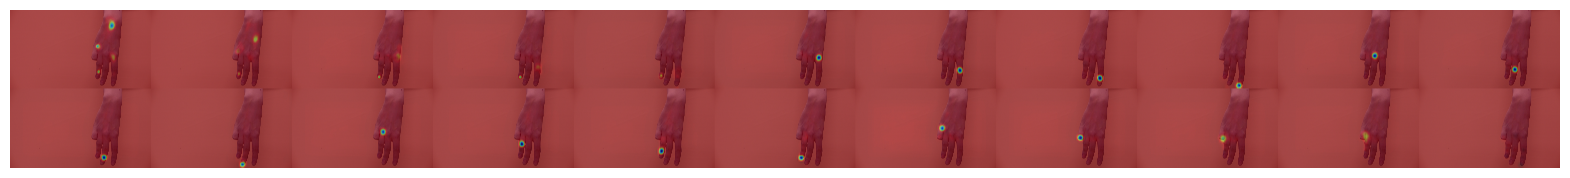

In [3]:
def visualize(heatmap):
    plt.figure(figsize=(20,20))
    bg_list = torch.from_numpy(np.transpose(np.array([oriImg[:, :, [2, 1, 0]]]*22), (0, 3, 1, 2)))
    w = oriImg.shape[0]
    max_value = np.max(heatmap_avg)
    min_value = np.min(heatmap_avg)
    img_list = []
    im = Image.open(test_image)
    for i in range(22):
        vis_img = (heatmap[:, :, i]-min_value)/max_value
        vis_img = Image.fromarray(np.uint8(cm.jet(vis_img) * 255))
        vis_img = vis_img.convert('RGB') # dropping alpha channel
        vis_img = Image.blend(im, vis_img, 0.5)
        vis_img = np.array(vis_img)
        img_list.append(np.transpose(vis_img, (2, 0, 1)))
    img_list = torchvision.utils.make_grid(torch.from_numpy(np.array(img_list)), nrow=11, padding=0)
    plt.imshow(np.transpose(img_list.numpy(), (1, 2, 0))[...,::-1]) # bgr to rgb
    plt.axis('off')
visualize(heatmap_avg)

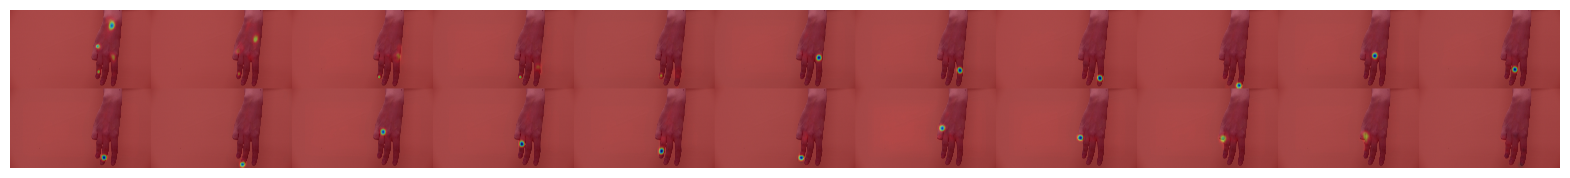

In [4]:
import copy
heatmap_1 = copy.deepcopy(heatmap_avg)
for part in range(21):
    map_ori = heatmap_1[:, :, part]
    one_heatmap = gaussian_filter(map_ori, sigma=3)
    heatmap_1[:, :, part] = one_heatmap
    
visualize(heatmap_1)

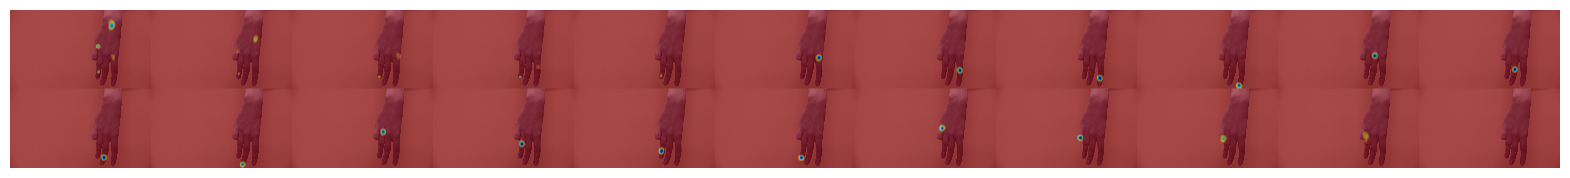

In [5]:
heatmap_2 = copy.deepcopy(heatmap_1)
heatmap_2[heatmap_2<thre] = 0
visualize(heatmap_2)

(-0.5, 4287.5, 2407.5, -0.5)

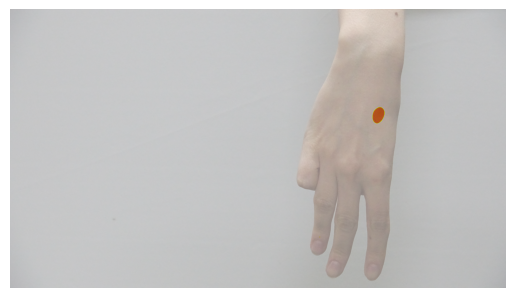

In [6]:
from skimage.measure import label

map_ori = heatmap_avg[:, :, 1]
one_heatmap = gaussian_filter(map_ori, sigma=3)
binary = np.ascontiguousarray(one_heatmap>0.05, dtype=np.uint8)
label_img, label_numbers = label(binary, return_num=True, connectivity = binary.ndim)
plt.imshow(oriImg[:, :, [2, 1, 0]])
plt.imshow(label_img, alpha=.5, cmap=plt.cm.hot_r)
plt.axis('off')



Text(3181, 921, '1')

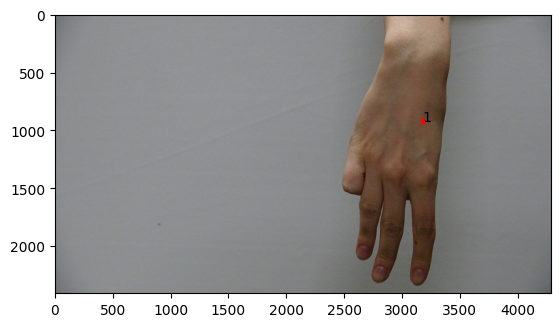

In [7]:
max_index = np.argmax([np.sum(map_ori[label_img == i]) for i in range(1, label_numbers+1)])+1
label_img[label_img!=max_index] = 0
map_ori[label_img==0] = 0
def npmax(array):
    arrayindex = array.argmax(1)
    arrayvalue = array.max(1)
    i = arrayvalue.argmax()
    j = arrayindex[i]
    return i, j
y, x = npmax(map_ori)

plt.imshow(oriImg[:, :, [2, 1, 0]])
plt.plot(x, y,'r.')
plt.text(x, y, '1')

In [8]:
all_peaks = []
for part in range(21):
    map_ori = heatmap_avg[:, :, part]
    one_heatmap = gaussian_filter(map_ori, sigma=3)
    binary = np.ascontiguousarray(one_heatmap>thre, dtype=np.uint8)

    if np.sum(binary)==0:
        all_peaks.append(-1)
        print("no ha añadido")
        continue
    label_img, label_numbers = label(binary, return_num=True, connectivity = binary.ndim)
    max_index = np.argmax([np.sum(map_ori[label_img == i]) for i in range(1, label_numbers+1)])+1
    label_img[label_img!=max_index] = 0
    map_ori[label_img==0] = 0
    def npmax(array):
        arrayindex = array.argmax(1)
        arrayvalue = array.max(1)
        i = arrayvalue.argmax()
        j = arrayindex[i]
        return i, j
    y, x = npmax(map_ori)
    all_peaks.append((x, y))

In [9]:
all_peaks

[(3098, 507),
 (3181, 921),
 (3260, 1432),
 (3202, 1754),
 (2666, 2019),
 (3176, 1473),
 (3181, 1859),
 (3153, 2098),
 (3096, 2322),
 (2938, 1420),
 (2914, 1831),
 (2860, 2094),
 (2787, 2305),
 (2781, 1316),
 (2711, 1682),
 (2677, 1898),
 (2638, 2105),
 (2639, 1206),
 (2560, 1492),
 (2611, 1512),
 (2664, 1464)]

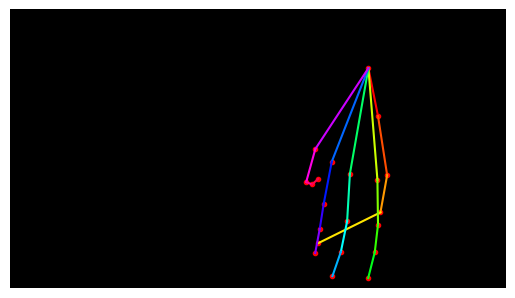

In [10]:
edges = [[0,1],[1,2],[2,3],[3,4],[0,5],[5,6],[6,7],[7,8],[0,9],[9,10], \
         [10,11],[11,12],[0,13],[13,14],[14,15],[15,16],[0,17],[17,18],[18,19],[19,20]]


blackImg = np.zeros_like(oriImg)
plt.imshow(blackImg[:, :, [2, 1, 0]])

for i, (x, y) in enumerate(all_peaks):
    plt.plot(x, y,'r.')
    #plt.text(x, y, str(i))
for ie, e in enumerate(edges):
    rgb = matplotlib.colors.hsv_to_rgb([ie/float(len(edges)), 1.0, 1.0])
    x1, y1 = all_peaks[e[0]]
    x2, y2 = all_peaks[e[1]]
    plt.plot([x1, x2], [y1, y2], color=rgb)
plt.axis('off')
plt.show()

In [5]:
def process_image(test_image, model, output_folder):
    oriImg = cv2.imread(test_image)  

    scale_search = [0.5, 1.0, 1.5, 2.0]
    boxsize = 368
    stride = 8
    padValue = 128
    thre = 0.05
    multiplier = [x * boxsize / oriImg.shape[0] for x in scale_search]
    heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 22))

    for m in range(len(multiplier)):
        scale = multiplier[m]
        imageToTest = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        imageToTest_padded, pad = util.padRightDownCorner(imageToTest, stride, padValue)
        im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5
        im = np.ascontiguousarray(im)

        data = torch.from_numpy(im).float()
        if torch.cuda.is_available():
            data = data.cuda()

        with torch.no_grad():
            output = model(data).numpy()

        # extract outputs, resize, and remove padding
        heatmap = np.transpose(np.squeeze(output), (1, 2, 0))  
        heatmap = cv2.resize(heatmap, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
        heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
        heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

        heatmap_avg += heatmap / len(multiplier)
    
    visualize_and_save(heatmap_avg, oriImg, output_folder, test_image)


def visualize_and_save(heatmap_avg, oriImg, output_folder, test_image):
    plt.figure(figsize=(20, 20))
    map_ori = heatmap_avg[:, :, 1]
    one_heatmap = gaussian_filter(map_ori, sigma=3)
    binary = np.ascontiguousarray(one_heatmap > 0.05, dtype=np.uint8)
    label_img, label_numbers = label(binary, return_num=True, connectivity=binary.ndim)
    

    max_index = np.argmax([np.sum(map_ori[label_img == i]) for i in range(1, label_numbers + 1)]) + 1
    label_img[label_img != max_index] = 0
    map_ori[label_img == 0] = 0

    def npmax(array):
        arrayindex = array.argmax(1)
        arrayvalue = array.max(1)
        i = arrayvalue.argmax()
        j = arrayindex[i]
        return i, j

    y, x = npmax(map_ori)

   

    all_peaks = []
    for part in range(21):
        map_ori = heatmap_avg[:, :, part]
        one_heatmap = gaussian_filter(map_ori, sigma=3)
        binary = np.ascontiguousarray(one_heatmap > thre, dtype=np.uint8)

        if np.sum(binary) == 0:
            all_peaks.append(-1)
            continue
        label_img, label_numbers = label(binary, return_num=True, connectivity=binary.ndim)
        max_index = np.argmax([np.sum(map_ori[label_img == i]) for i in range(1, label_numbers + 1)]) + 1
        label_img[label_img != max_index] = 0
        map_ori[label_img == 0] = 0

        def npmax(array):
            arrayindex = array.argmax(1)
            arrayvalue = array.max(1)
            i = arrayvalue.argmax()
            j = arrayindex[i]
            return i, j

        y, x = npmax(map_ori)
        all_peaks.append((x, y))

    edges = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], [0, 9], [9, 10], \
             [10, 11], [11, 12], [0, 13], [13, 14], [14, 15], [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]

    blackImg = np.zeros_like(oriImg)
    plt.imshow(blackImg[:, :, [2, 1, 0]])

    for i, (x, y) in enumerate(all_peaks):
        plt.plot(x, y, 'r.')

    for ie, e in enumerate(edges):
        rgb = matplotlib.colors.hsv_to_rgb([ie / float(len(edges)), 1.0, 1.0])
        x1, y1 = all_peaks[e[0]]
        x2, y2 = all_peaks[e[1]]
        

    plt.axis('off')
    plt.savefig(os.path.join(output_folder, 'openPose_' + os.path.basename(test_image)), bbox_inches='tight', pad_inches=0)
    plt.close()

def process_images_in_folder(folder_path, output_folder, model):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.JPG') or filename.endswith('.jpg'):
            test_image = os.path.join(folder_path, filename)
            try:
                process_image(test_image, model, output_folder)
            except:
                
                continue
       
model = handpose_model()
model_dict = torch.load('hand_pose_model.pth')
model.load_state_dict(util.transfer(model, model_dict))

input_folder = "data_openpose/m"
output_folder = "DATA_Openpose/M"

process_images_in_folder(input_folder, output_folder, model)
